In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from cycler import cycler

%matplotlib inline
color_cycle = cycler('color',['#377eb8','#4daf4a','#e41a1c','#984ea3','#ff7f00','#a65628','#f781bf','#999999','#ffff33'])
mpl.rc('figure',figsize=[2.7,1.6])
mpl.rc('font',size=8.0)
#mpl.rcParams['font.sans-serif'] = 'Helvetica'
mpl.rc('lines',linewidth=0.7) 
mpl.rc('axes',prop_cycle=color_cycle,grid=True,linewidth=0.5,axisbelow=True,unicode_minus=False)
mpl.rc('grid',linewidth=0.3,linestyle=':')
mpl.rc('legend',fontsize='medium',framealpha=1.0,numpoints=1)
mpl.rc('svg',fonttype='none')
mpl.rc('savefig',dpi=300)
import numpy as np
from numpy import pi
import sys

In [2]:
sys.path.append('../../../../../share/python/') # correct relative path
def getResults(filename):
    from hdf5_tools import get_result, get_centroids, get_step_values
    from h5py import File
    h5 = File(filename)
    r = {}
    try :
        regions = ['V'] #
        for result in ['magFieldIntensity','magFluxDensity','magTotalCurrentDensity']:
            vals = []
            for reg in regions:
                vals.append( get_result(h5,result,reg,step='all',multistep=1) )
            r[result] = np.vstack(vals)
        vals = []
        for reg in regions:
            vals.append( get_centroids(h5,reg) )
        r['cent'] = np.vstack(vals)
        r['stepval'] = get_step_values(h5)
        h5.close()
    except Exception as e:
        h5.close()
        print(e)
    return r


In [95]:
MAT='analytic-exp'  #'analytic-sqrt'  # 'analytic-exp' #'analytic-linear'#'analytic-rayleigh' #'analytic-bilinear' #'analytic-poly-3'
trans = getResults('results_hdf5/run_%s_transient.cfs'%MAT)

Ns = np.argsort(trans['cent'][:,-1])
Np = Ns[[0,-1]]
fig,ax = plt.subplots()

ax.plot( trans['stepval'][-1], trans['magFluxDensity'][:,Np,0] )
ax.legend(['z=%.2f'%val for val in trans['cent'][Np,-1]])
ax.set_xlim(0,2*pi)
ax.set_xlabel('Time in s')
ax.set_ylabel('B in T')

In [4]:
def harmonic2time(vals_harmonic,f=None,Nt=20):
    from numpy import pi
    if f is None:
        Nh = int(vals_harmonic.shape[0]/2)
        hs = np.arange(1,2*Nh,2)
        f = np.hstack([-hs[::-1],hs])/2/pi
    else :
        Nh = int(len(f)/2)
    t = np.linspace(0,1/f[Nh],Nt*((Nh-1)*2+1))
    return t,np.tensordot(np.exp(1j*2*pi*np.outer(t,f)),vals_harmonic,(-1,0)).real

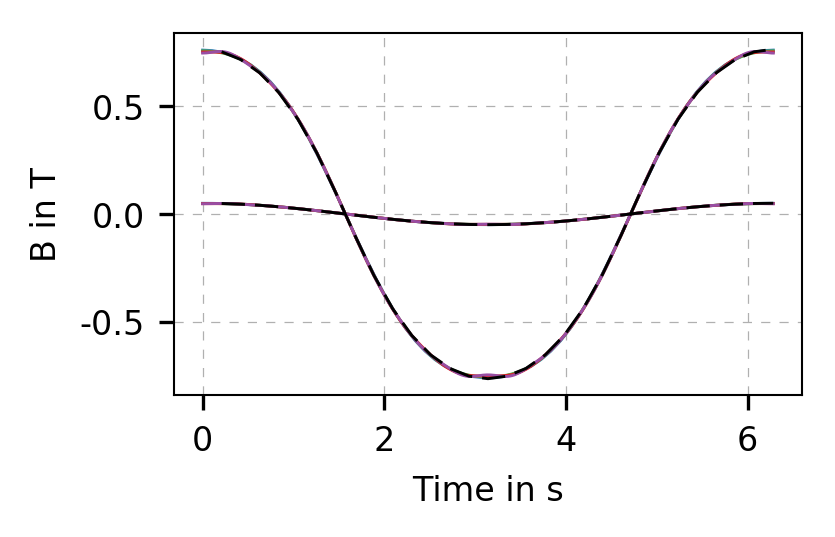

In [96]:
mharm = {}
N = [3,7,11,15]
for n in N:
    mharm[n] = getResults('results_hdf5/run_%s_mh%i.cfs'%(MAT,n))
fig,ax = plt.subplots()
for n in N:
    t,B = harmonic2time(mharm[n]['magFluxDensity'])
    l, = ax.plot(t,B[:,Np[0],0],label=n)
    for i in range(1,len(Np)):
        ax.plot(t,B[:,Np[i],0],color=l.get_color())
ax.plot( trans['stepval'][-1], trans['magFluxDensity'][:,Np,0],'--k' )
ax.set_xlabel('Time in s')
ax.set_ylabel('B in T')

In [52]:
mharm[15]['stepval'][-1]

array([-15., -13., -11.,  -9.,  -7.,  -5.,  -3.,  -1.,   1.,   3.,   5.,
         7.,   9.,  11.,  13.,  15.])

(0, 0.1)

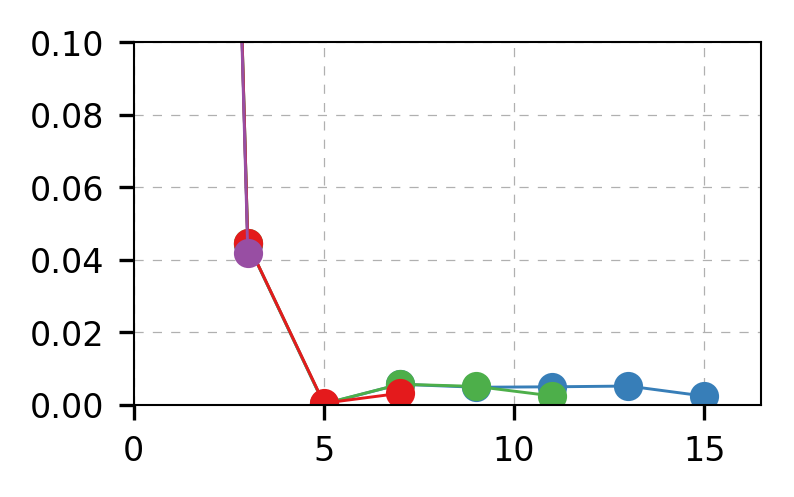

In [82]:
fig,ax = plt.subplots()
#n = 3
p = 1
for n in N[::-1]:
    ax.plot( mharm[n]['stepval'][-1],np.abs(mharm[n]['magFluxDensity'][:,Np[p],0]),'-o' )
ax.set_xlim(0)
lim = 0.1
ax.set_ylim(0,lim)
# this is probably due to oversampling in the nFFT points

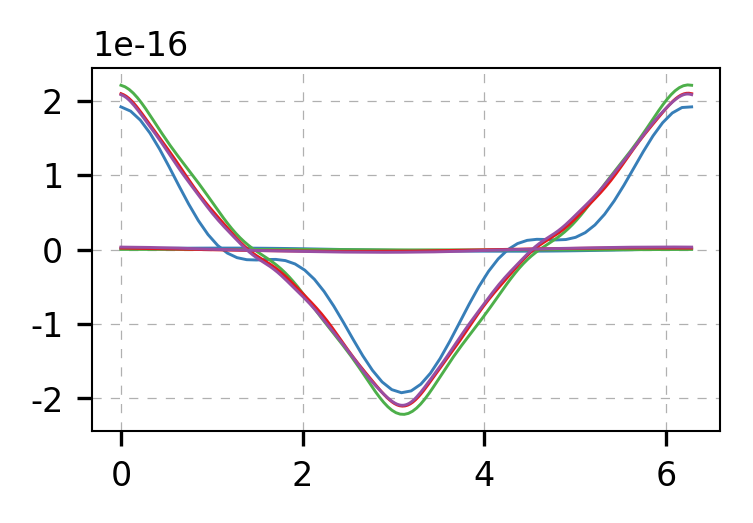

In [6]:
fig,ax = plt.subplots()
for n in N:
    t,B = harmonic2time(mharm[n]['magFieldIntensity'])
    l, = ax.plot(t,B[:,Np[0],0],label=n)
    for i in range(1,len(Np)):
        ax.plot(t,B[:,Np[i],0],color=l.get_color())
#ax.plot( trans['stepval'][-1], trans['magFieldIntensity'][:,Np,0],'--k' )

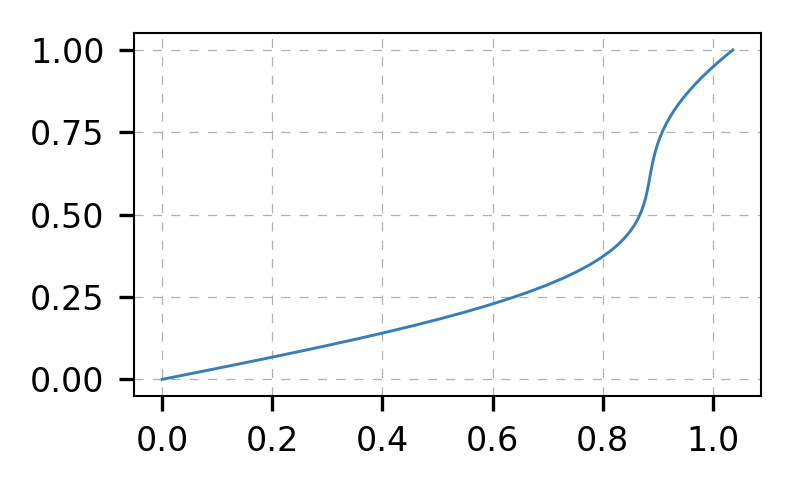

In [7]:
# exp BH-curve
B_R = np.linspace(0,1)
k2 = -4
k1 = 2 #0.005#/np.exp(k2)
k3 = 1.0
H = (k1*np.exp(k2*B_R*B_R)+k3)*B_R
fig,ax=plt.subplots()
ax.plot(H,B_R)
#ax.set_xlim(0,1)

In [8]:
# polynomial BH-curve
B = np.linspace(0,1)
p = np.array([1,1,1,1])
p = p/np.sum(p)
H = np.array([p[i]*B**(i+1) for i in range(len(p))]).sum(axis=0)
nu = np.array([p[i]*B**(i) for i in range(len(p))]).sum(axis=0)
nu_deriv = np.array([i*p[i]*B**(i-1) for i in range(1,len(p))]).sum(axis=0)
fig,ax=plt.subplots()
ax.plot(H,B)
#ax2 = ax.twinx()
#ax2.plot(B,nu_deriv,'k')
#ax2.plot(B[1:],np.diff(H/B)/np.diff(B))

In [9]:
# Rayleigh region : M(H) = a H + b H^2
B0 = 0.01
B = np.linspace(B0,1)
a = 1
b = 2
mu0 = 1/(1+a+b)
H = -(1+a)/(2*b) + np.sqrt(((1+a)/(2*b))**2+1/(mu0*b)*B)
fig,ax=plt.subplots()
ax.plot(B,H/B)
ax2=ax.twinx()
ax2.plot(B[1:],np.diff(H/B)/np.diff(B),'--')
B_R = B
from numpy import sqrt as Sqrt
nu_deriv = (-2*b*B - (1 + a)**2*mu0 + (1 + a)*b*mu0*Sqrt((4*b*B + (1 + a)**2*mu0)/(b**2*mu0)))/(2.*b**2*B**2*mu0*Sqrt((4*b*B + (1 + a)**2*mu0)/(b**2*mu0)))
H[0]/B[0]
ax2.plot(B,nu_deriv)
#ax.set_xlim(0,1)